## Picking Smarter Games in League of Legends
- Creator: Jacky Dam
- LinkedIn: https://www.linkedin.com/in/jackydam/
- GitHub: https://github.com/jacky3331

## Summary of Findings

### Introduction
League of Legends is a popular team-based strategy game where players are able to select champions (characters with unique fighting abilities) and work together to destroy the enemys' base. Before starting a competitive ranked match, players are queued up in a matchmaking lobby in which each of the two teams alternate between picking a unique champion visible to everyone before the game start. A ranked champion selection demo can be found in the later sections.

With the ability to scrape large datasets of League of Legends match history information, I explored the possibility of creating models which would be able to predict the winning team given the champion team compositions. If it was possible to create a model that is able to predict the outcome of a ranked game with a reasonable performance (better than 50%), then it would allow players to make a better informed decision of dodging a less ideal game to preserve champion stats and improve global player ranking.

### Data Collection
By learning how to utilize the official Riot Games API library (Cassiopeia), I was able to generate a large dataset of match history information to start my technical analysis. This API library is available to the public with a certain limit restriction of how much player data could be retrieved per minute. The script I used for this project can be found in the same folder with this python notebook. More information about the Cassiopeia API library can be found below:
- https://github.com/meraki-analytics/cassiopeia

### Cleaning and EDA
Since I utilized a script to collect lots of match history information, I need to create a method to process the raw data in order to ensure that the model isn't working with duplicate/incomplete match information. Additionally, I chose to select certain columns which includes: match id, team color, team position, champion, kills, deaths, assists, and whether they won their game.

In my Exploratory Data Analysis, I drew inference from visualizing the win rates of the champions and illustrated the popularity of the champions by the number of games played. Through my analysis, I am able to observe interesting trends which I would later use to build the perfect team composition with my predictive model.

### Model Selection

### Results & Outcome

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
import random

from IPython.display import YouTubeVideo
from tabulate import tabulate

### Ranked Champion Selection Demo (optional)

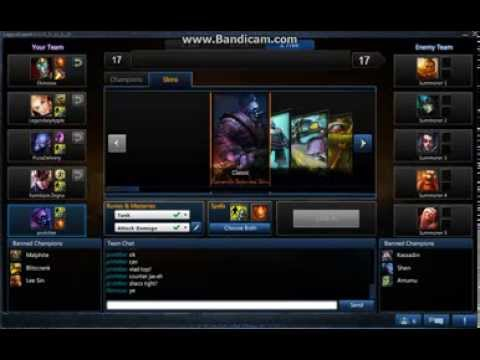

In [2]:
YouTubeVideo("CfXQrfhFRnI")

## Code

### Processing & Cleaning

In [3]:
def clean_data(match_history):
    # Make a copy of the dataframe
    df = match_history.copy()
    
    # Select columns we want to work with
    df = df[["match_id", "side", "team_position", "champion", "kills", "deaths", "assists", "win"]]
    df = df.drop_duplicates()
    
    # Drop player information if match is incomplete i.e. match id does not contain 10 players
    df = df[df["match_id"].map((df["match_id"].value_counts()==10))]
    
    return df

In [4]:
match_history = pd.read_csv("match_history.csv")
match_history.head()

,match_id,duration,summoner_name,side,team_position,summoner_level,win,champion,kills,deaths,assists,damage_to_turrets,gold_earned,turret_takedowns,vision_score,minions_killed,first_blood,first_tower
0,4306514682,0:00:01.822000,top is weakside,blue,top_lane,48,False,Malphite,1,8,8,323,8539,0,26,150,False,False
1,4306514682,0:00:01.822000,Bellydrum,blue,jungle,248,False,Graves,12,10,8,743,14714,0,90,81,True,False
2,4306514682,0:00:01.822000,Roh Jungeui,blue,mid_lane,433,False,Sylas,9,9,10,1954,12959,1,13,183,False,False
3,4306514682,0:00:01.822000,sun kissed dawn,blue,bot_lane,41,False,Lucian,5,9,10,1944,11379,0,16,190,False,False
4,4306514682,0:00:01.822000,Verayson,blue,utility,109,False,Rakan,3,6,16,0,8784,0,70,34,False,False


In [5]:
# There are 29353 rows of player data, and 18 different column features
match_history.shape

(34361, 18)

In [6]:
# Check for duplicate/incomplete data (match_ids with more or less than 10 players)
match_history['match_id'].value_counts().sort_values()

4304892065      1
4303458524      3
4305634239      4
4305773030      4
4304402761      4
             ... 
4305878645     70
4305922045     80
4306420131     90
4306514682    100
4305980817    100
Name: match_id, Length: 2734, dtype: int64

In [7]:
df = clean_data(match_history)
df.head()

,match_id,side,team_position,champion,kills,deaths,assists,win
0,4306514682,blue,top_lane,Malphite,1,8,8,False
1,4306514682,blue,jungle,Graves,12,10,8,False
2,4306514682,blue,mid_lane,Sylas,9,9,10,False
3,4306514682,blue,bot_lane,Lucian,5,9,10,False
4,4306514682,blue,utility,Rakan,3,6,16,False


In [8]:
# Validate the shape of our cleaned dataframe
df.shape

(27120, 8)

In [9]:
# Validate that our cleaned dataframe doesn't have duplicate/incomplete data (match_ids with more or less than 10 players)
df['match_id'].value_counts().sort_values()

4303216652    10
4302149827    10
4307085501    10
4306046994    10
4306190360    10
              ..
4271376223    10
4298264438    10
4305825690    10
4307121969    10
4294744029    10
Name: match_id, Length: 2712, dtype: int64

In [10]:
# Validate that we aren't working with incomplete missing data
df.isna().sum()

match_id         0
side             0
team_position    0
champion         0
kills            0
deaths           0
assists          0
win              0
dtype: int64

In [11]:
# Validate data types of each column feature
df.dtypes

match_id          int64
side             object
team_position    object
champion         object
kills             int64
deaths            int64
assists           int64
win                bool
dtype: object

Our method of cleaning the dataframe looks correct, now we can get into our analysis...

### Exploratory Data Analysis

In the figures below, we can observe the champions with the lowest and highest win rates. After creating our model, we will see whether we determine the probability of winning with fixed team compositions with the information shown in the bar plots above.

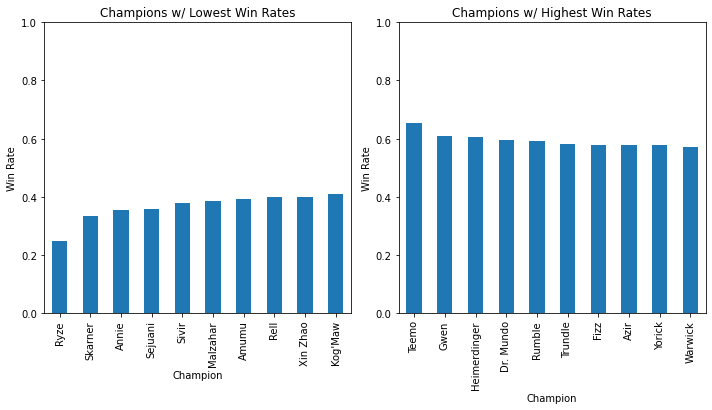

In [12]:
champion_dist = (
    df.pivot_table(index="win", 
                   columns="champion",
                   aggfunc="size")
)

champion_dist = champion_dist/champion_dist.sum()
champion_dist = champion_dist.T

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
fig.delaxes(axs[1][1])
fig.delaxes(axs[1][0])

ax = champion_dist[True].sort_values(ascending=True)[:10].plot.bar(ax=axs[0][0], title="Champions w/ Lowest Win Rates")
ax.set_xlabel("Champion")
ax.set_ylabel("Win Rate")
ax.set_ylim(0,1)

ax = champion_dist[True].sort_values(ascending=False)[:10].plot.bar(ax=axs[0][1], title="Champions w/ Highest Win Rates")
ax.set_xlabel("Champion")
ax.set_ylabel("Win Rate")
ax.set_ylim(0,1)

fig.tight_layout()
plt.show()

In the figure below, we can observe the popularity of all the champions selected by the players in our data set. A quick overview of the plot indicate players are selective of the characters they choose to play League of Legends with. 

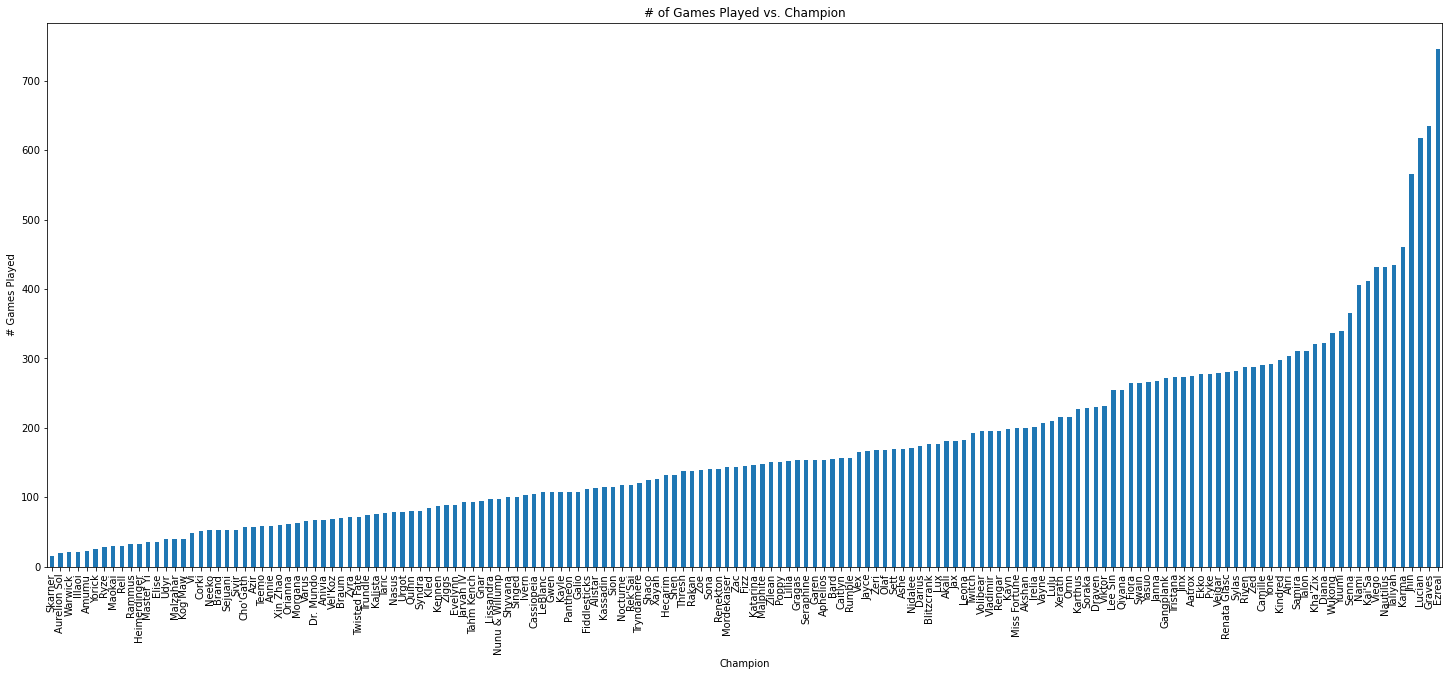

In [13]:
plt.figure(figsize=(25,10))
df.groupby("champion").count()["match_id"].rename("# Games Played").sort_values(ascending=True).plot.bar(title="# of Games Played vs. Champion")
plt.ylabel("# Games Played")
plt.xlabel("Champion")
plt.show()

The tables shown below display the champions with the most and least games played.

In [14]:
print(df.groupby("champion").count()["match_id"].rename("# Games Played").sort_values(ascending=False)[:10].to_markdown())

| champion   |   # Games Played |
|:-----------|-----------------:|
| Ezreal     |              746 |
| Graves     |              635 |
| Lucian     |              617 |
| Jhin       |              565 |
| Karma      |              460 |
| Taliyah    |              434 |
| Nautilus   |              432 |
| Viego      |              431 |
| Kai'Sa     |              412 |
| Nami       |              405 |


In [15]:
print(df.groupby("champion").count()["match_id"].rename("# Games Played").sort_values(ascending=True)[:10].to_markdown())

| champion     |   # Games Played |
|:-------------|-----------------:|
| Skarner      |               15 |
| Aurelion Sol |               20 |
| Warwick      |               21 |
| Illaoi       |               21 |
| Amumu        |               23 |
| Yorick       |               26 |
| Ryze         |               28 |
| Maokai       |               30 |
| Rell         |               30 |
| Rammus       |               33 |


### Predictive Model (Logistic Regression)

In [16]:
def feat(datum):
    feat = [1]
    for champion_selected in datum:
        champion = [0]*len(champion_dict)
        champion[champion_dict[champion_selected]] = 1
        feat += champion
    return feat

In [17]:
# Prepare the team composition data with their win label
data = df.groupby(["match_id", "win"])["champion"].apply(list).unstack()

# Set aside a test set of size 298.
reserved_test = data.iloc[:298]

output = [(i, True) for i in data[True].values]
output += [(i, False) for i in data[False].values]

In [18]:
data.head()

win,False,True
match_id,,
4167993974,"[Camille, Graves, Orianna, Jhin, Thresh]","[Gwen, Shaco, Yasuo, Kai'Sa, Alistar]"
4168019856,"[Yone, Jarvan IV, Yasuo, Caitlyn, Lux]","[Sett, Shaco, Vex, Draven, Pyke]"
4168150884,"[Jayce, Taliyah, Viktor, Caitlyn, Shen]","[Mordekaiser, Lee Sin, Ahri, Alistar, Jhin]"
4168188605,"[Tryndamere, Olaf, Akali, Heimerdinger, Rakan]","[Camille, Rek'Sai, Viktor, Ezreal, Leona]"
4168265192,"[Wukong, Graves, Yone, Jhin, Xerath]","[Camille, Ekko, Corki, Ashe, Vex]"


In [19]:
output[:5]

[(['Gwen', 'Shaco', 'Yasuo', "Kai'Sa", 'Alistar'], True),
 (['Sett', 'Shaco', 'Vex', 'Draven', 'Pyke'], True),
 (['Mordekaiser', 'Lee Sin', 'Ahri', 'Alistar', 'Jhin'], True),
 (['Camille', "Rek'Sai", 'Viktor', 'Ezreal', 'Leona'], True),
 (['Camille', 'Ekko', 'Corki', 'Ashe', 'Vex'], True)]

In [20]:
# Create a dictionary for the unique champions in the game to prep for one-hot-encoding
champion_dict = dict(enumerate(np.unique([i[0] for i in output])))
champion_dict = dict((v,k) for k,v in champion_dict.items())

In [21]:
X = [feat(d[0]) for d in output]
y = [d[1] for d in output]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", fit_intercept=True, C=1, class_weight="balanced")
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced')

In [23]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_test, y_test))

Training Accuracy: 0.6310209725743259
Validation Accuracy: 0.511520737327189


Looking at the results of my Logistic Regression model, the model appears to perform well on the training set but perform poorly on the validation set. Although the results don't appear very impressive, this accuracy is misleading because it doesn't evaluate the accuracy of predicting the winning team out of two different team compositions. I will evaluate the true performance of the model on the test set after implementing other models.

### Predictive Model (Random Forest)

In [24]:
model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [25]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_test, y_test))

Training Accuracy: 0.708919105784743
Validation Accuracy: 0.48847926267281105


In [26]:
data.head()

win,False,True
match_id,,
4167993974,"[Camille, Graves, Orianna, Jhin, Thresh]","[Gwen, Shaco, Yasuo, Kai'Sa, Alistar]"
4168019856,"[Yone, Jarvan IV, Yasuo, Caitlyn, Lux]","[Sett, Shaco, Vex, Draven, Pyke]"
4168150884,"[Jayce, Taliyah, Viktor, Caitlyn, Shen]","[Mordekaiser, Lee Sin, Ahri, Alistar, Jhin]"
4168188605,"[Tryndamere, Olaf, Akali, Heimerdinger, Rakan]","[Camille, Rek'Sai, Viktor, Ezreal, Leona]"
4168265192,"[Wukong, Graves, Yone, Jhin, Xerath]","[Camille, Ekko, Corki, Ashe, Vex]"


In [27]:
reserved_test.head()

win,False,True
match_id,,
4167993974,"[Camille, Graves, Orianna, Jhin, Thresh]","[Gwen, Shaco, Yasuo, Kai'Sa, Alistar]"
4168019856,"[Yone, Jarvan IV, Yasuo, Caitlyn, Lux]","[Sett, Shaco, Vex, Draven, Pyke]"
4168150884,"[Jayce, Taliyah, Viktor, Caitlyn, Shen]","[Mordekaiser, Lee Sin, Ahri, Alistar, Jhin]"
4168188605,"[Tryndamere, Olaf, Akali, Heimerdinger, Rakan]","[Camille, Rek'Sai, Viktor, Ezreal, Leona]"
4168265192,"[Wukong, Graves, Yone, Jhin, Xerath]","[Camille, Ekko, Corki, Ashe, Vex]"


In [28]:
reserved_test["Probability of Winning (False)"] = [model.predict_proba([feat(i)])[0][1] for i in reserved_test[False].values]
reserved_test["Probability of Winning (True)"] = [model.predict_proba([feat(i)])[0][1] for i in reserved_test[True].values]
reserved_test = reserved_test[[False, "Probability of Winning (False)", True, "Probability of Winning (True)"]]

<ipython-input-28-a4e630d7e56f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_test["Probability of Winning (False)"] = [model.predict_proba([feat(i)])[0][1] for i in reserved_test[False].values]
<ipython-input-28-a4e630d7e56f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_test["Probability of Winning (True)"] = [model.predict_proba([feat(i)])[0][1] for i in reserved_test[True].values]


In the cell above, I used the model to predict the probability of winning for both team compositions in a match.

In [29]:
reserved_test.head(20)

win,False,Probability of Winning (False),True,Probability of Winning (True)
match_id,,,,
4167993974,"[Camille, Graves, Orianna, Jhin, Thresh]",0.484968,"[Gwen, Shaco, Yasuo, Kai'Sa, Alistar]",0.518139
4168019856,"[Yone, Jarvan IV, Yasuo, Caitlyn, Lux]",0.495983,"[Sett, Shaco, Vex, Draven, Pyke]",0.542935
4168150884,"[Jayce, Taliyah, Viktor, Caitlyn, Shen]",0.491679,"[Mordekaiser, Lee Sin, Ahri, Alistar, Jhin]",0.498324
4168188605,"[Tryndamere, Olaf, Akali, Heimerdinger, Rakan]",0.500558,"[Camille, Rek'Sai, Viktor, Ezreal, Leona]",0.488743
4168265192,"[Wukong, Graves, Yone, Jhin, Xerath]",0.482397,"[Camille, Ekko, Corki, Ashe, Vex]",0.495669
4168337089,"[Riven, Graves, Ryze, Kai'Sa, Karma]",0.457119,"[Zed, Viego, Malzahar, Jhin, Pyke]",0.525712
4168350291,"[Kled, Graves, Twisted Fate, Kog'Maw, Bard]",0.508978,"[Nasus, Lee Sin, Malzahar, Jinx, Lulu]",0.488092
4172216681,"[Camille, Viego, Malzahar, Jinx, Nautilus]",0.467169,"[Tryndamere, Zed, Twisted Fate, Ezreal, Rakan]",0.479087
4181062332,"[Aatrox, Kayn, Sylas, Swain, Nautilus]",0.492366,"[Yone, Diana, Yasuo, Jinx, Lulu]",0.497475


In [30]:
# Calculate the accuracy of the model when comparing the probability of winning for two opposing team compositions
result = (reserved_test["Probability of Winning (True)"] > reserved_test["Probability of Winning (False)"]).mean()
print("Accuracy (Test Set): " + str(result))

Accuracy (Test Set): 0.7550335570469798


In the previous section, I reserved about 298 samples from the data set which was never used to train the models. The flaw of the accuracy that we evaluated for the training set and test set was that it was evaluating whether a single team composition would win the game; however a specific team composition doesn't necessarily imply an automatic win. The way that I evaluated the performance of my model is by calculating the probablity of winning for both team compositions in a single match, and having the model determine the winning team by choosing the team composition with the highest probability of winning. We can observe that the accuracy is quite high compared to my previous iterations of this notebook, and make a better informed decision by comparing the probability of winning for the two team compositions.

### Summary of Results

Although the results of the training set and validation was decieving, I was able to significantly improve my model compared to previous iteration and earn an accuracy of about 77% on the test set. By comparing the probability of winning of the two team compositions during champion selection, players will be able to have an edge in climbing global rankings by having the ability to make a better informed decision and dodge a potentially devasting game of League of Legends.

There are definely improvements that could be made on this model performance. In this project, I primarily focused on the population of high-ranking players which introduced bias into this model. It would make to sense to explore other model options such as boosting algorithms, decision trees, etc., look into collecting more sample data, and create a nicer user interface where players can input team composition information to get the probablity of winning.